* ### Для загрузки датасета начать [отсюда](#Препроцессинг-выборки) и идти до следующего раздела.

In [3]:
import keras
import gc
import pandas as pd
import os
import json, pickle as pkl
import seaborn as sns
from tqdm import tqdm
from itertools import chain

%pylab inline

PATH_TO_DATA = '/media/grigory/Data/WIKIDATA'

/home/grigory/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/grigory/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('prepared_info.csv',sep=',',quotechar='/', index_col='id')

выберем только авторов, чье общее число произведений в выборке больше 100

In [3]:
df = df[df['total_count']>100] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57686 entries, 0 to 94991
Data columns (total 11 columns):
categories     57416 non-null object
article_url    57686 non-null object
name           57632 non-null object
author         57686 non-null object
translator     7332 non-null object
author_url     57686 non-null object
verified       57686 non-null bool
content_len    57686 non-null int64
oldspell       57686 non-null bool
cats           57416 non-null object
total_count    57686 non-null int64
dtypes: bool(2), int64(2), object(7)
memory usage: 4.5+ MB


выкинем переводы

In [4]:
df = df[df['translator'].isnull()]

In [5]:
# (df['author']+df['name']+df['content_len'].astype('str')).apply(hash).value_counts()

выберем категорию, с которой будем работать, ибо большая величина $\sigma$ числа токенов в тексте - не путь джедая(скорее всего тупо не заведётся).

In [6]:
df['cats'] = df['cats'].fillna('[]')
df['cats'] = df['cats'].apply(eval)

In [7]:
pd.Series(list(chain.from_iterable(df['cats']))).value_counts().head(5)

Русская поэзия, малые формы                 34816
Поэзия Константина Дмитриевича Бальмонта     8580
Восьмистишия                                 5781
Списки редакций                              4068
Русская проза, малые формы                   3377
dtype: int64

Есть <img src="https://cs9.pikabu.ru/post_img/2017/02/24/5/1487918509199879809.jpg" width=100px style="display:inline;">:

    1. работать с русской прозой, ибо большие тексты легче классифицировать. Здесь нужно юзать ebmedding'
    2. работать с русской поэзией, и юзать char-rnn, потому что в некоторых текстах вообще по 50 символов
    
**Update** (нашёлся третий стул):
> можно забить на категории и просто взять из выборки те тексты, которые нам нравятся по размеру.

In [8]:
# prose_mask = df['cats'].apply(lambda _: ("Русская проза, малые формы" in _) \
#                                            if _ not in [None,nan] else False)
# df = df[prose_mask]

In [11]:
# # выбираем авторов, где больше всего статей
# authors = df['author'].value_counts()[0:10]
# mask = df['author'].apply(lambda x: x in authors)
# truncated_data = df[mask]
# N = 1000
# # из получившейся выборки  берём N сэмплов
# # np.random.choice(truncated_data.index,N) эта с повторениями, а нужно без
# idx = np.random.permutation(truncated_data.index)[:N]
# truncated_data = truncated_data.loc[idx,:]
# truncated_data.loc[idx,:].author.value_counts()

In [30]:
texts = []
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    file_ = os.path.join(PATH_TO_DATA, str(i)+'.json')
    with open(file_,'rb') as f:
        fcontent = json.load(f)    
    text = fcontent['content']
    texts.append(text)

100%|██████████| 57686/57686 [12:15<00:00, 78.38it/s]


In [ ]:
data = pd.DataFrame({'text': texts, 'author': df['author'].values})

In [45]:
%%time
data.to_csv('dataset.csv', index=False)

## Препроцессинг выборки

In [20]:
data = pd.read_csv('dataset.csv')

**Update**:

каким-то образом в выборке всё таки оказались дублирующиеся тексты.

Вычистим их, взяв хэш от самого текста. Можно,конечно, и проще как-то так...: 
```python 
hash(имя автора+имя текста+...)
```
но не будем искать лёгких путей).

In [21]:
data['text_hash'] = data['text'].apply(hash)
hashes_counts = data['text_hash'].value_counts()
bad_hashes = set(hashes_counts[hashes_counts!=1].index)
good_hashes = set(hashes_counts[hashes_counts==1].index)

In [22]:
selection = []
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    hash_ = row['text_hash']
    if hash_ in bad_hashes:
        selection.append(i)
        bad_hashes = bad_hashes - set([hash_])
    elif hash_ in good_hashes:
        selection.append(i)

100%|██████████| 57686/57686 [00:09<00:00, 6119.43it/s]


In [23]:
data = data.loc[selection, :]

не забываем, что выбрали третий, \**мистический*\*, стул, который предполагает, что мы отфильтруем произведения по числу символов на месте.

Вспомним, как выглядит распределения кол-ва символов в текстах:

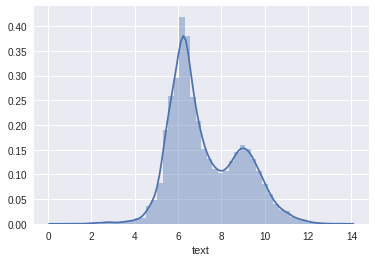

In [24]:
sns.distplot(data['text'].apply(len).apply(np.log));

Выберем приемлимую длину текста, стараясь оставить как можно больше вероятностной массы

In [25]:
lens = data['text'].apply(len).apply(np.log)
length_mask = (lens>8) & (lens<10)                  # exp(8) ~= 2981, exp(10) ~= 22027
data = data[length_mask]

смотрим, чтобы не было совсем уж редких авторов

In [26]:
samples_threshold = 25
counts = data.author.value_counts()
data = data[data.author.isin(counts[counts.values>samples_threshold].index)]

print('Осталось {} сэмплов и {} уникальных автора'.format(data.shape[0], data.author.value_counts().shape[0]))

Осталось 7767 сэмплов и 56 уникальных автора


вновнь глянем на длину текста

In [41]:
print(data.loc[751,'text'])





Еще один май кончился, и опять отцвела акация. Кажется, ничто так не характерно для Одессы, ничто так ее не напоминает вдали, как запах акации. Даже море. Во-первых, море на море не похоже: под Петербургом море бледное, подлинялое, «малосольное», как где-то кто-то выразился, и напомнить наше море оно может только по контрасту; а где-нибудь в Мессине или у берегов Крита море опять-таки другое, гораздо лучше нашего, и, глядя на ту роскошную синеву, трудно перенестись мыслью на Ланжерон. Акация же, где бы ни пахла, пахнет одинаково. Во-вторых — убеждены ли мы, что всякий одессит обязательно знает море? Мой знакомый учитель в одной школе на Молдаванке опросил как-то свой класс, и оказалось, что четыре малыша, лет по семи-девяти, никогда не видали море. В этом нет ничего невероятного. Я знал в Риме людей, там родившихся и выросших, которые никогда за всю жизнь не были в соборе св. Петра.

Вообще человек далеко не так любопытнее, не так жаден до впечатлений, как это считается. Но нет так

фильтруем символы

In [16]:
ALLOWED_CHARS = {chr(chr_idx) for chr_idx in range(ord('а'), ord('я')+1)}
ALLOWED_CHARS |= set('ё,.—?!: \t\n') #«»
print(len(ALLOWED_CHARS))

42


In [17]:
%%time
data['text'] = data['text'].str.strip()
data['text'] = data['text'].str.lower()

CPU times: user 708 ms, sys: 96 ms, total: 804 ms
Wall time: 810 ms


In [18]:
data['text'] = data['text'].apply(lambda item: ''.join(filter(lambda ch: ch in ALLOWED_CHARS, item)))

Стоп слова, по идее, лучше оставить, потому что должны помогать определять авторский стиль, но позже попоробуем и без них.

In [23]:
# import nltk
# #nltk.FreqDist() # фигня для подсчёта количества
# from nltk.corpus import stopwords
# stop = set(stopwords.words('russian'))
# len(stop)

'уважаемый гн н. н. в своем письме вы упрекаете то политическое объединение, к которому я принадлежу, что оно не конструктивно. другие течения имеют колонии, банки и тому подобное, а мы только критикуем.\n\nвопервых, я с вами даже в отношения фактов не согласен. старшее поколение этой критикующей партии состоит из людей, большинство которых приняло очень большое участие в создании как раз этих конструктивноматериальных ценностей сионистского движения. вы, например, пишете, что не можете получить визу на посещение тельавивской выставки. очень жалко, что вы не сможете ее осмотреть. вы бы испытали много удовольствия, и она бы вам дала много полезного. левантийская выставка в действительности большое и замечательное дело. от нее можно многому научиться, как от прохождения целого университетского факультета.\n\nно еще сильнее, чем учебная польза, то влияние, которое она имеет, то руководящее значение, которое левантская выставка себе завоевала во всей экономической жизни палестины. но, я на


### Препроцессинг входных данных

### Токенизация
Ссылки по теме:
- [Простая токенизация с помощью nltk](http://igorshevchenko.ru/blog/entries/textrank)
- [Умная токенизация для русского языка](https://github.com/mithfin/Sentence-Splitter-for-Russian)

Вопросы и задачи:

- что делать с кавычками «» ?
    - выкинуть/игнорировать
    - оставить(надо писать свою регулярку или, возможно, добавлять везде отступы перед и после них)
- выкинуть чиселки
- выкинуть прямые ссылки на автора в тексте

    
готовые опции:

- https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
```python
from keras.preprocessing.text import Tokenizer
```
Проблемы с тем, что нет нормализации и настройки токенизации
-

In [28]:
import nltk
import pymorphy2
from nltk.stem.snowball import RussianStemmer

from nltk.tokenize import RegexpTokenizer
base_tokenizer = nltk.word_tokenize
regexp_tokenizer = RegexpTokenizer(r'\w+').tokenize 

# Выбираем лемматизатор
lems = True
if lems:
    morph = pymorphy2.MorphAnalyzer()
    lmtzr = lambda token: morph.parse(token)[0].normal_form    
else:
    lmtzr = RussianStemmer().stem
    
def prepare_sample(sentence, tokenizer=base_tokenizer):
    for word in tokenizer(sentence.lower()):
        yield lmtzr(word) 

test_sent = data['text'][0]
#list(prepare_sample(test_sent))

In [191]:
X = []
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    X.append(list(prepare_sample(row['text'])))
print(len(X))

100%|██████████| 11033/11033 [1:45:17<00:00,  1.75it/s]

11033


сохраняем токенизированные, лемматизированные тексты и метки к ним на диск

In [2]:
# сохраним всю эту хрень на диск
TEMP_PATH = '/media/grigory/Data/DIPLOM_DATA'
ifp = os.path.join(TEMP_PATH, 'tokenized_input.json') #input file
ofp = os.path.join(TEMP_PATH, 'labels.json')  # output file
dfp = os.path.join(TEMP_PATH, 'encoded_dict.pkl')  # most freq words dict file

In [230]:
import json
with open(ifp,'w') as f:
    json.dump(X, f)
print('Input saved!')
with open(ofp,'w') as f:
    json.dump(data['author'].values.tolist(), f)
print('Labels saved!')

Input saved!
Labels saved!


## Получение embedding'ов
работа с готовыми vs. подготовка своих на отдельно vs. обучение своих на ходу

Ссылки по теме:
- [Обучение собственных embedding'ов с помощью gensim либы](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)
- [gensim](https://becominghuman.ai/word-embeddings-with-gensim-68e6322afdca)
- [Обучение собственных embedding'ов (вместе с описанием подготовки)](https://www.quora.com/How-can-one-train-own-word-embeddings-like-word2vec)
- [Видосик про обучение](https://www.youtube.com/watch?time_continue=5445&v=U0LOSHY7U5Q)

Тренированный word2vec:
- [Обученные эмбеддинги](http://rusvectores.org/ru/models/)

Глянуть чат ODS, канал nlp. Много кейсов

### Обучение Embedding на  всей выборке. Пакет GenSim, word2Vec

In [61]:
%%time
from gensim.models import Word2Vec
# define training data
sentences = X_train
# train model
model = Word2Vec(sentences, min_count=1)
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
new_model

Word2Vec(vocab=16156, size=100, alpha=0.025)
CPU times: user 2.7 s, sys: 44 ms, total: 2.75 s
Wall time: 1.56 s


In [75]:
model.wv['который'];

### Работа с готовыми Embedding'ами

Потенциальные траблы:

- многие embedding обучены без стоп-слов. В задаче определения авторства они скорее нужны. Помимо этого, удалена и пунктуация, которая тоже может оказаться полезной.

In [67]:
from gensim.models import KeyedVectors
filename = 'embeddings/ruscorpora_upos_skipgram_300_5_2018.vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [73]:
model.wv['птица_NOUN'];

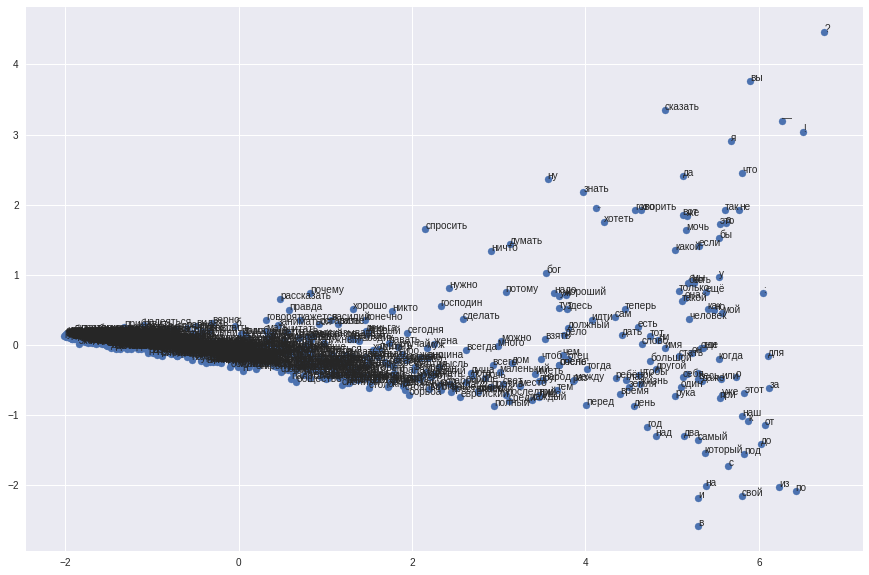

In [65]:
from sklearn.decomposition import PCA
plt.figure(figsize=(15,10));
slice_len = 1000
vocab_slice = list(model.wv.vocab.keys())[:slice_len]
words = model.wv[vocab_slice]
pca = PCA(n_components=2)
result = pca.fit_transform(words)
# отрисовка
pyplot.scatter(result[:, 0], result[:, 1])
words = list(vocab_slice)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

#pyplot.show()


## LSTM

- [Классификация текстов lstm сетями](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
- [пример с Kaggle](https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout-lb-0-048)

### LSTM на embedding'ах

In [158]:
seed = 7
numpy.random.seed(seed)
params = dict(
    seed = seed,  # fix random seed for reproducibility
)

### Загрузка подготовленных данных

In [159]:
# dataset params
params['dp'] = dict(   
    top_words = 5000,
    max_review_length = 1000,
    train_test_split = 0.2,
    train_val_split=0.2,
)

In [160]:
%%time
with open(ifp,'r') as f:
    X = json.load(f)
with open(ofp,'r') as f:
    y = json.load(f)

CPU times: user 8.94 s, sys: 1.95 s, total: 10.9 s
Wall time: 21.9 s


In [161]:
from collections import Counter
N_frequent = params['dp']['top_words']
words = Counter(chain.from_iterable(X))
freq_words = dict((word, idx)for idx,(word, count) in enumerate(words.most_common(N_frequent)))

кодируем наиболее популярные слова чиселками, а остальные нулями

In [162]:
X_encoded = []
for sample in tqdm(X):
    encoded = [freq_words.get(word,0) for word in sample]
    X_encoded.append(encoded)
# sanity check
print(len(set(chain.from_iterable(X_encoded))))

100%|██████████| 11033/11033 [00:04<00:00, 2295.57it/s]


5000


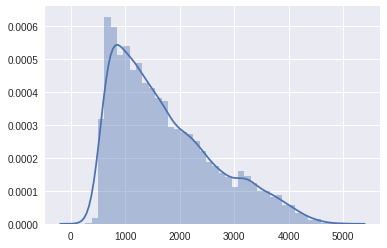

In [163]:
lens= []
for sample in X_encoded:
    lens.append(len(sample))
lens = pd.Series(lens)
sns.distplot(lens);
plt.show();

Выберем макисмальное число токенов в последовательности, ориентируясь на плотность.

In [164]:
from keras.preprocessing import sequence
maxlen = params['dp']['max_review_length']
X = sequence.pad_sequences(X_encoded, maxlen=maxlen)
np.array(X).shape

(11033, 1000)

In [165]:
from scipy.sparse import csr_matrix
with open(os.path.join(TEMP_PATH, 'train_samples.pkl'),'wb') as f:
    pkl.dump(csr_matrix(X), f)

### Загружаем данные

In [20]:
%%time
import json, pickle as pkl
with open(os.path.join(TEMP_PATH, 'train_samples.pkl'),'rb') as f:
    X_sparse = pkl.load(f)
with open(os.path.join(TEMP_PATH, 'labels.json'),'r') as f:
    labels = json.load(f)

NameError: name 'TEMP_PATH' is not defined

In [167]:
X = X_sparse.todense()
print(X.shape, len(labels))
print('Итого:')
print('Число уникальных слов:', np.unique(np.array(X)).shape[0])
print('Число классов:', np.unique(np.array(labels)).shape[0])
print('Длина последовательностей:', X.shape[1])

(11033, 1000) 11033
Итого:
Число уникальных слов: 5000
Число классов: 64
Длина последовательностей: 1000


кодируем целевую переменную и бъём на train/test

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# encode classes
le = LabelEncoder()
le.fit(labels)
y = le.transform(labels)

y = keras.utils.to_categorical(y)
# do train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            test_size=params['dp']['train_test_split'], stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                            test_size=params['dp']['train_val_split'], stratify=y_train)
total = X.shape[0]
print('Train:{:.3f}, Val:{:.3f}, Test:{:.3f}'.format(X_train.shape[0]/total,
                                X_val.shape[0]/total, X_test.shape[0]/total))

Train:0.640, Val:0.160, Test:0.200


In [196]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
# create the model

model = Sequential()
embedding_vector_length = 32
model.add(Embedding(top_words, embedding_vector_length, input_length=maxlen))
model.add(LSTM(32, dropout=0.6)) # 64
#model.add(Dropout(0.4))
model.add(Dense(64, activation='softmax'))

In [197]:
optimizer = optimizers.Adam()#(lr=1e-2)#, decay=5e-3),
# train params
params['tp'] = dict(                      
    batch_size=64,
    epochs=60,
    optimizer=optimizer.get_config(),
    opt_name=optimizer.__class__.__name__,
    
)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
#model.summary()

In [198]:
# Готовим callbacks
earlystopper = EarlyStopping(monitor='val_acc', patience=15, verbose=1)
checkpointer = ModelCheckpoint('lstm.h5', monitor='val_acc',verbose=1, save_best_only=True)
tensorboard = TensorBoard()               # по умолчанию пишет в logs директорию          
reduce_lr = ReduceLROnPlateau(patience=3) # после 3 шагов, при которых score на валидации не рос, понизит lr.

model.fit(X_train, y_train, epochs=params['tp']['epochs'], batch_size=params['tp']['batch_size'], 
          validation_data=(X_val,y_val), 
          callbacks=[earlystopper, checkpointer, reduce_lr, tensorboard], 
          verbose=1);

Train on 7060 samples, validate on 1766 samples
Epoch 1/60
7060/7060 [==============================] - 68s 10ms/step - loss: 3.8480 - acc: 0.1006 - val_loss: 3.6799 - val_acc: 0.1036
Epoch 2/60
7060/7060 [==============================] - 65s 9ms/step - loss: 3.6501 - acc: 0.1237 - val_loss: 3.5485 - val_acc: 0.1529
Epoch 3/60
7060/7060 [==============================] - 64s 9ms/step - loss: 3.3940 - acc: 0.1735 - val_loss: 3.3200 - val_acc: 0.1682
Epoch 4/60
7060/7060 [==============================] - 69s 10ms/step - loss: 3.1490 - acc: 0.2195 - val_loss: 3.2188 - val_acc: 0.2005
Epoch 5/60
7060/7060 [==============================] - 68s 10ms/step - loss: 2.9226 - acc: 0.2738 - val_loss: 2.9628 - val_acc: 0.2769
Epoch 6/60
7060/7060 [==============================] - 66s 9ms/step - loss: 2.6741 - acc: 0.3306 - val_loss: 3.0602 - val_acc: 0.2282
Epoch 7/60
7060/7060 [==============================] - 61s 9ms/step - loss: 2.5144 - acc: 0.3630 - val_loss: 2.7414 - val_acc: 0.3194
Epoc

KeyboardInterrupt: 

In [199]:
# Final evaluation of the model
tr_scores = model.evaluate(X_train, y_train, verbose=1)
print("Train Accuracy: %.2f%%" % (tr_scores[1]*100))
val_scores = model.evaluate(X_val, y_val, verbose=1)
print("Val. Accuracy: %.2f%%" % (val_scores[1]*100))
te_scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy: %.2f%%" % (te_scores[1]*100))

7060/7060 [==============================] - 18s 3ms/step

In [195]:
""" будем хранить параметры, описание архитектуры и результаты в одном json, а веса отдельно"""
name = 'models/lstm_{:.10}'.format(str(abs(hash(tuple(params)))))
config_data = {
    'scores': {
        'train': tr_scores[1],
        'val': val_scores[1],
        'test': te_scores[1],
    },
    'params': params,
    'model': model.to_json()
}
with open(name+'.json', "w") as f:
    f.write(json.dumps(config_data, indent=4))
model.save_weights(name+'.h5')

загружаем обученную модель

In [152]:
# from keras.models import model_from_json
# name = 'lstm_2809725967'
# with  open(name+'.json', 'r') as f:
#     config = json.loads(f.read())
#     model = model_from_json(config['model'])
# # load weights into new model
# model.load_weights(name+'.h5')
# model.compile(loss='categorical_crossentropy', 
#               optimizer=optimizers.Adam(lr=1e-2),#, decay=5e-3),
#               metrics=['accuracy'])
# print(model.summary())

### Char LSTM 

- [paper1](https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)

### LSTM и CNN

https://github.com/alexeyev/CNN-for-Sentence-Classification-in-Keras

### bag of words

Ссылки по теме:
- [Работа с текстом в scikit](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

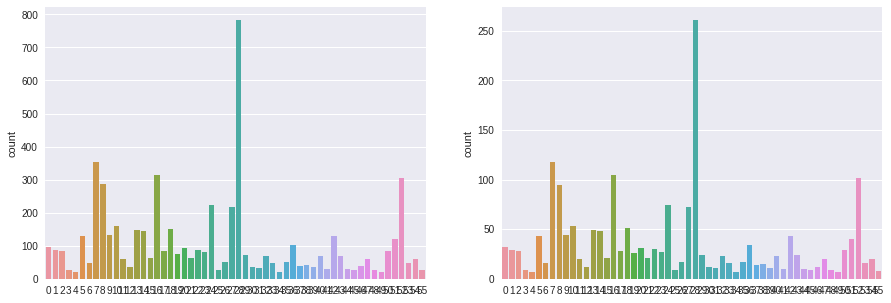

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

corpus = data.reset_index(drop=True)
X, y = corpus['text'],corpus['author']

# encode classes
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

# do train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# sanity check for stratified split
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(y_train);
plt.subplot(1,2,2)
sns.countplot(y_test);

In [25]:
%%time
from  sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10**5)
vectorizer.fit(X_train)
X_train, X_test = vectorizer.transform(X_train), vectorizer.transform(X_test)

/home/grigory/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


CPU times: user 21.8 s, sys: 76 ms, total: 21.9 s
Wall time: 22.3 s


In [26]:
%%time
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
lr = LogisticRegression()
#lr.fit(X_train, y_train)


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
lr_params = {
    'C': np.logspace(-1,1, 3),#np.logspace(-4,3, 8),
    'penalty': ['l1','l2']
}
grid = GridSearchCV(lr, lr_params, verbose=2, n_jobs=-1)#, random_state=8)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1, penalty=l1 ...............................................
[CV] C=0.1, penalty=l1 ...............................................
[CV] C=0.1, penalty=l1 ...............................................
[CV] C=0.1, penalty=l2 ...............................................
[CV] C=0.1, penalty=l2 ...............................................
[CV] C=0.1, penalty=l2 ...............................................
[CV] C=1.0, penalty=l1 ...............................................
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total= 1.3min
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total= 1.3min
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l1, total= 1.3min
[CV] C=1.0, penal

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  6.8min remaining:  2.6min


[CV] ............................... C=10.0, penalty=l1, total= 4.9min
[CV] ............................... C=10.0, penalty=l1, total= 2.7min
[CV] ............................... C=10.0, penalty=l2, total= 3.0min
[CV] ............................... C=10.0, penalty=l2, total= 1.8min
[CV] ............................... C=10.0, penalty=l2, total= 1.6min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([ 0.1,  1. , 10. ]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [27]:
grid.best_score_, grid.best_params_

(0.8760515021459228, {'C': 10.0, 'penalty': 'l2'})

In [30]:
from sklearn.metrics import accuracy_score
grid.score(X_test,y_test)

0.907826982492276

сохраняем модель на диск.

In [43]:
import pickle as pkl
with open('logtest90.pkl','wb') as f:
    pkl.dump(grid, f)
with open('labelencoder.pkl','wb') as f:
    pkl.dump(le, f)
with open('tfidf.pkl','wb') as f:
    pkl.dump(vectorizer, f)

In [44]:
with open('logtest90.pkl','rb') as f:
    classifier = pkl.load(f)
classifier.score(X_test, y_test)

0.907826982492276

In [58]:
id_ = 5
data.loc[0,'author'], data.loc[0,'text']

('Владимир Евгеньевич Жаботинский',
 '\n\n\n\nУважаемый г-н Н. Н. В своем письме Вы упрекаете то политическое объединение, к которому я принадлежу, что оно не «конструктивно». Другие течения имеют колонии, банки и тому подобное, а мы «только критикуем».\n\nВо-первых, я с Вами даже в отношения фактов не согласен. Старшее поколение этой критикующей партии состоит из людей, большинство которых приняло очень большое участие в создании как раз этих конструктивно-материальных ценностей сионистского движения. Вы, например, пишете, что не можете получить визу на посещение Тель-Авивской выставки. Очень жалко, что Вы не сможете ее осмотреть. Вы бы испытали много удовольствия, и она бы Вам дала много полезного. Левантийская выставка в действительности большое и замечательное дело. От нее можно многому научиться, как от прохождения целого университетского факультета.\n\nНо еще сильнее, чем учебная польза, то влияние, которое она имеет, то руководящее значение, которое Левантская выставка себе заво

In [48]:
le.inverse_transform(2)

/home/grigory/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Александр Иванович Куприн'

### Другое:

https://github.com/brightmart/text_classification